In [1]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import Preprocessor
from src.lstm_forecasting import LSTMForecaster
from sklearn.metrics import mean_squared_error

# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

In [2]:
# champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
# convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('../data/events/football_matches_2024_2025.csv')

# Handling missing values in target columns

In [14]:
sts_peres_df.isna().sum()/sts_peres_df["Identifiant arc"].count()

Identifiant arc              0.000000
Libelle                      0.000000
Date et heure de comptage    0.000000
Débit horaire                0.851165
Taux d'occupation            0.851165
Etat trafic                  0.000000
Identifiant noeud amont      0.000000
Libelle noeud amont          0.000000
Identifiant noeud aval       0.000000
Libelle noeud aval           0.000000
Etat arc                     0.000000
Date debut dispo data        0.000000
Date fin dispo data          0.000000
geo_point_2d                 0.000000
geo_shape                    0.000000
date                         0.000000
hour                         0.000000
year                         0.000000
month                        0.000000
weekday                      0.000000
is_weekend                   0.000000
hour_sin                     0.000000
hour_cos                     0.000000
weekday_sin                  0.000000
weekday_cos                  0.000000
month_sin                    0.000000
month_cos   

# Preprocessing using class Preprocessor

In [3]:
preprocessor = Preprocessor(df=sts_peres_df)

# On applique ton pipeline de preprocessing
df_processed = preprocessor.fit_transform(holidays_df=holidays_df, weather_df=weather_df, sports_df=football_matches_df)

print("Preprocessed Data :", df_processed.shape)
display(df_processed.sample(5))


Preprocessed Data : (8627, 45)


,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,wind_speed_10m (km/h),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),apparent_temperature (°C),rain (mm),sport_event_name,is_sport_event,Débit horaire_outlier_iqr,Taux d'occupation_outlier_iqr
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2025-09-09 12:00:00,191,Sts_Peres,730.485728,11.813306,Inconnu,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,...,3.4,1.0,1010.4,48.0,20.4,0.0,NaN,False,False,False
2024-11-12 14:00:00,191,Sts_Peres,475.000000,14.510560,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2025-04-16 09:00:00,191,Sts_Peres,624.845500,9.886037,Inconnu,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2024-10-03 17:00:00,191,Sts_Peres,771.000000,13.103890,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
2025-08-27 20:00:00,191,Sts_Peres,721.328434,11.646243,Inconnu,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


# LSTM Forecasting

In [4]:
forecaster = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False,
    use_outliers=True
)

# Preparation of sequences
X_train, X_test, y_train, y_test = forecaster.prepare_data(df_processed)

# Training
history = forecaster.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)


Epoch 1/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 0.0278 - val_loss: 0.0159
Epoch 2/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0077 - val_loss: 0.0146
Epoch 3/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0063 - val_loss: 0.0105
Epoch 4/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0054 - val_loss: 0.0109
Epoch 5/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.0043 - val_loss: 0.0126


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Débit horaire : RMSE = 119.64, Mean = 701.45, Relative error = 17.06%
Taux d'occupation : RMSE = 2.31, Mean = 11.22, Relative error = 20.56%


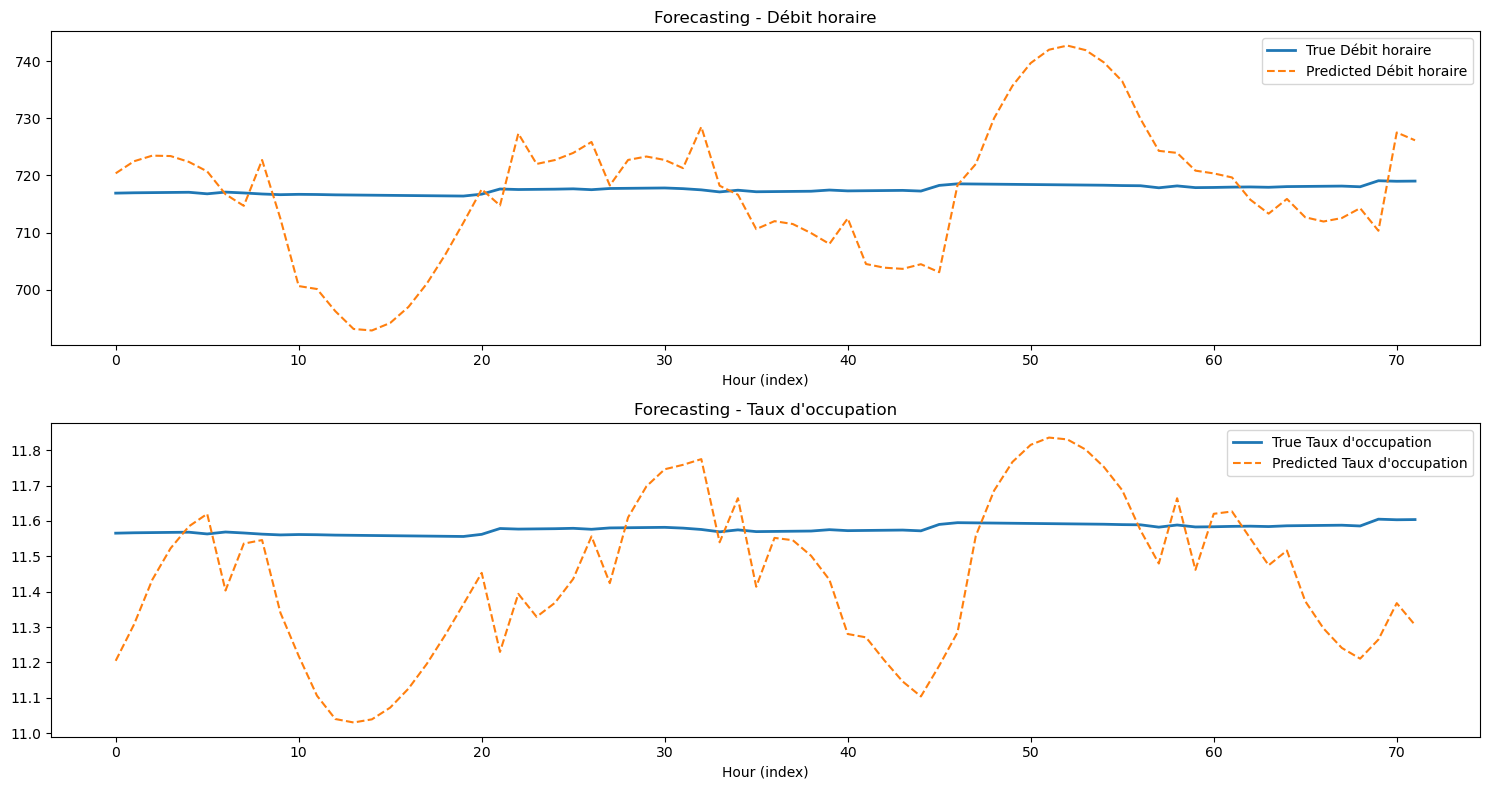

In [5]:
y_test_inv, y_pred_inv = forecaster.evaluate(X_test, y_test)

# Visualisation on the first 72 hours
forecaster.plot_predictions(y_test_inv, y_pred_inv, n_plot=72)

In [6]:
# Concaténer train + test pour la CV (on prend tout)
X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

forecaster.time_series_cv(X_all, y_all, n_splits=5, epochs=5, batch_size=32)

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0763 - val_loss: 0.0068
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0291 - val_loss: 0.0035
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0262 - val_loss: 0.0039
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0240 - val_loss: 0.0042
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0209 - val_loss: 0.0056
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Débit horaire : RMSE = 71.51, Mean = 567.53, Relative error = 12.60%
Taux d'occupation : RMSE = 1.23, Mean = 8.84, Relative error = 13.89%
Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0426 - val_loss: 0.0048
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0162 - val_loss: 0.0033
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0141 - val_loss: 0.0019
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0127 - val_loss: 9.5804e-04
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0

# XGBoost model

In [7]:
from src.xgb_forecasting import XGBoostModel

Train set: (1417, 8), Test set: (72, 8) (72 hours)
Débit horaire : RMSE = 100.91, Mean = 435.24, Relative Error = 23.19%
Taux d'occupation : RMSE = 1.72, Mean = 5.70, Relative Error = 30.20%


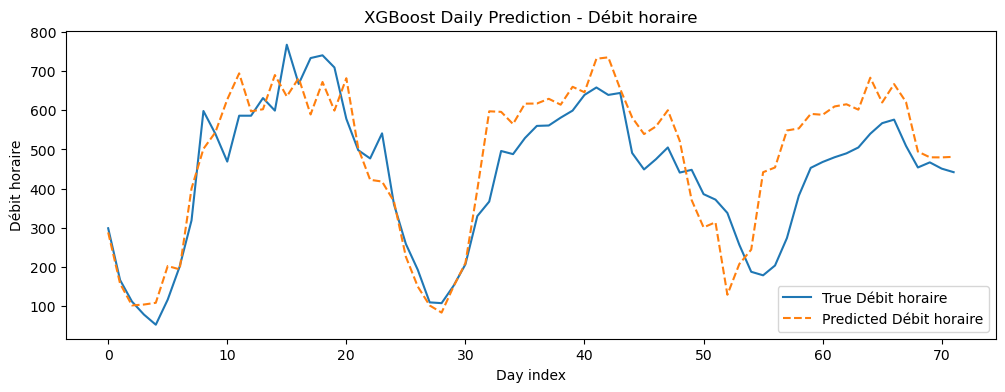

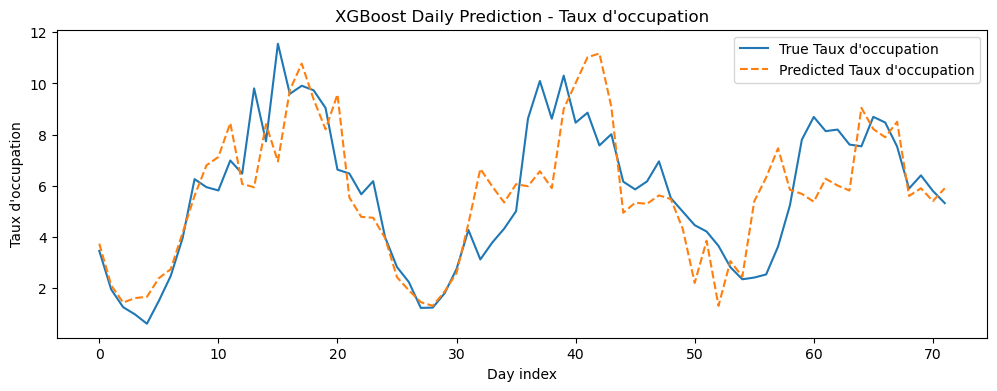

In [8]:
targets = ['Débit horaire', "Taux d'occupation"]
features_xgb = ['is_holiday',
                'is_sport_event',
                'temperature_2m (°C)','wind_speed_10m (km/h)',
                'precipitation (mm)','cloud_cover (%)'] 

df_xgb = df_processed.copy()
df_xgb['lag_1d'] = df_xgb['Débit horaire'].shift(24)
df_xgb['lag_1w'] = df_xgb['Débit horaire'].shift(24*7)

features_xgb += ['lag_1d', 'lag_1w']

df_xgb = df_xgb.dropna(subset=['lag_1d', 'lag_1w'] + targets).copy()

xgb_model = XGBoostModel(df_xgb, features_xgb, targets)
xgb_model.prepare_data(horizon=72)

xgb_model.fit()

# Prediction on the test set
y_test, y_pred = xgb_model.evaluate()

# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test[:, i], label=f"True {target}")
    plt.plot(y_pred[:, i], '--', label=f"Predicted {target}")
    plt.title(f"XGBoost Daily Prediction - {target}")
    plt.xlabel("Day index")
    plt.ylabel(target)
    plt.legend()
    plt.show()



In [9]:
cv_results = xgb_model.cross_validate(n_splits=5)

Débit horaire : CV RMSE mean = 43.03, std = 22.48
Taux d'occupation : CV RMSE mean = 1.54, std = 0.86


# Hybrid LSTM + XGBoost model 

In [10]:
## Hybrid LSTM + XGBoost model

### LSTM for short-term patterns
lstm_model = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = lstm_model.prepare_data(df_processed)

# Training
history = lstm_model.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)

# Predictions LSTM
y_test_inv, y_pred_inv = lstm_model.evaluate(X_test, y_test)

### XGBoost for long-term patterns
# Compute daily averages
# daily_df = df_processed.groupby('date').agg({
#     'Débit horaire':'mean',
#     "Taux d'occupation":'mean',
#     'is_holiday':'first',
#     'is_sport_event':'first',
#     'temperature_2m (°C)':'mean',
#     'wind_speed_10m (km/h)':'mean',
#     'precipitation (mm)':'mean',
#     'cloud_cover (%)':'mean'
# }).reset_index()

# Features for XGBoost
features_xgb = ['is_holiday','is_sport_event','temperature_2m (°C)',
                'wind_speed_10m (km/h)','precipitation (mm)','cloud_cover (%)']

# Instanciate XGBoost
xgb_model = XGBoostModel(df_processed, features_xgb, lstm_model.targets)
xgb_model.prepare_data(horizon=72)
xgb_model.fit()

# Predictions XGBoost (long-term)
y_pred_xgb = xgb_model.predict()


Epoch 1/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - loss: 0.0281 - val_loss: 0.0164
Epoch 2/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0076 - val_loss: 0.0127
Epoch 3/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 0.0063 - val_loss: 0.0112
Epoch 4/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 0.0052 - val_loss: 0.0126
Epoch 5/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0042 - val_loss: 0.0111
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Débit horaire : RMSE = 124.24, Mean = 701.45, Relative error = 17.71%
Taux d'occupation : RMSE = 2.34, Mean = 11.22, Relative error = 20.89%
Train set: (1417, 6), Test set: (72, 6) (72 hours)


In [11]:
# Combine LSTM and XGBoost predictions
y_test_inv, y_pred_lstm_array = lstm_model.evaluate(X_test, y_test)
print("LSTM Prediction Array Shape :", y_pred_lstm_array.shape)
y_pred_lstm_hourly = y_pred_lstm_array[-1, :, :]

alpha = 0.7
y_pred_final = alpha * y_pred_lstm_hourly + (1-alpha) * y_pred_xgb
print("Final Prediction Shape :", y_pred_final.shape)

y_true = y_test_inv[-1, :, :]  # real 72h for the last batch of LSTM
y_pred = y_pred_final           # 72h combined LSTM + XGBoost

for i, target in enumerate(lstm_model.targets):
    rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i])**2))
    mean_val = np.mean(y_true[:, i])
    rel_error = 100 * rmse / mean_val
    print(f"{target} : RMSE = {rmse:.2f}, Mean = {mean_val:.2f}, Relative Error = {rel_error:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Débit horaire : RMSE = 124.24, Mean = 701.45, Relative error = 17.71%
Taux d'occupation : RMSE = 2.34, Mean = 11.22, Relative error = 20.89%
LSTM Prediction Array Shape : (1678, 72, 2)
Final Prediction Shape : (72, 2)
Débit horaire : RMSE = 175.10, Mean = 434.49, Relative Error = 40.30%
Taux d'occupation : RMSE = 3.49, Mean = 5.69, Relative Error = 61.42%


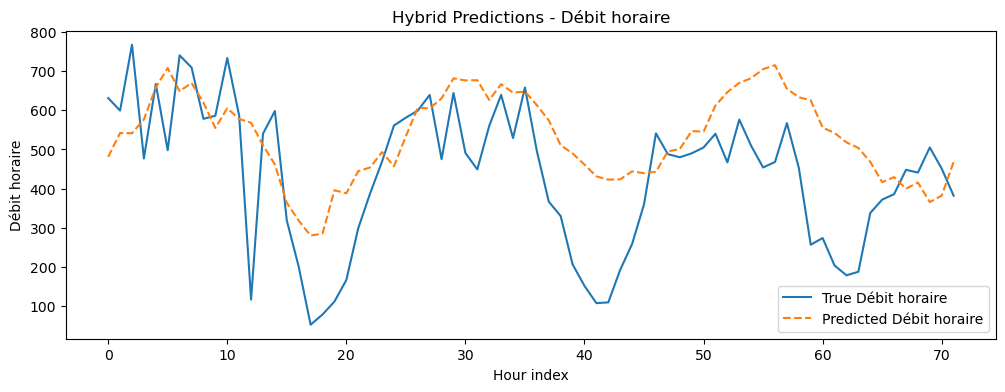

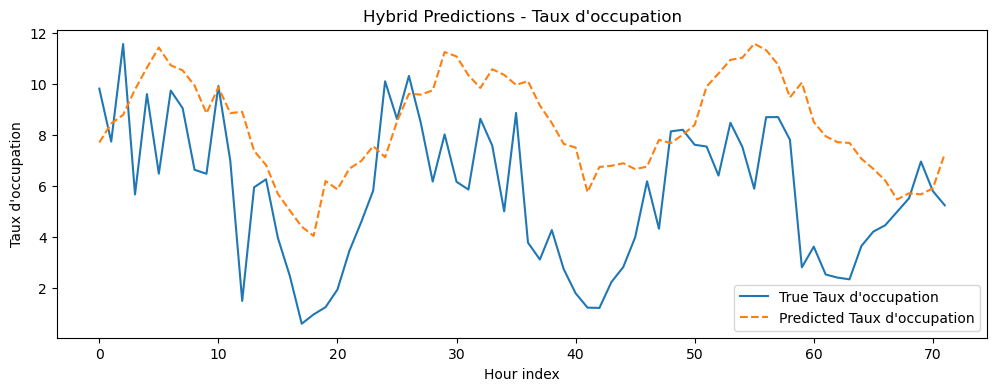

In [12]:
# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test_inv[-1, :, :][:, i], label=f"True {target}")
    plt.plot(y_pred_final[:, i], '--', label=f"Predicted {target}")
    plt.title(f"Hybrid Predictions - {target}")
    plt.xlabel("Hour index")
    plt.ylabel(target)
    plt.legend()
    plt.show()